<a href="https://colab.research.google.com/github/ChelseaOwiti/Colposcopy-Scan/blob/model/Version_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
import keras
import os
import glob
from skimage import io
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install torchmetrics timm
import gc

In [4]:
import cv2
import seaborn as sns
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, models, transforms
import torch
from cv2 import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torchmetrics 
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn
from torch.optim import AdamW,Adam # optmizers
import time
from tqdm import tqdm

%config Completer.use_jedi = False

In [6]:
dataset_path = "/content/drive/MyDrive/archive/kaggle/train/train"
train_classes = ['Type_1', 'Type_2', 'Type_3']


In [10]:
file_path = os.path.join(dataset_path, train_classes[2], '*')
file_path = glob.glob(file_path)
print(len(file_path))
image = io.imread(file_path[12])



450


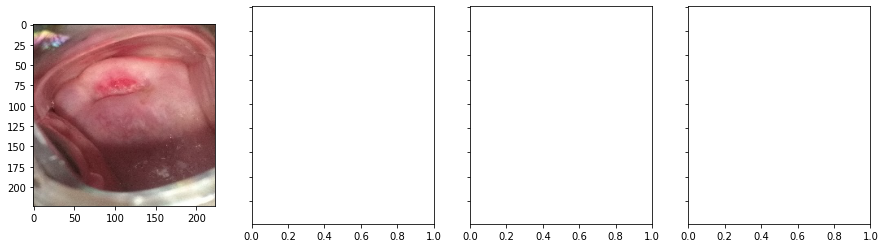

In [11]:
norm1_image = image/255
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(norm1_image)

In [12]:
print(f'Train set has a total of {len(file_path)}')

Train set has a total of 450


In [13]:
epochs = 5
output_path = './'
batch_size = 10

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device(device)
cpu = torch.device('cpu')

cpu


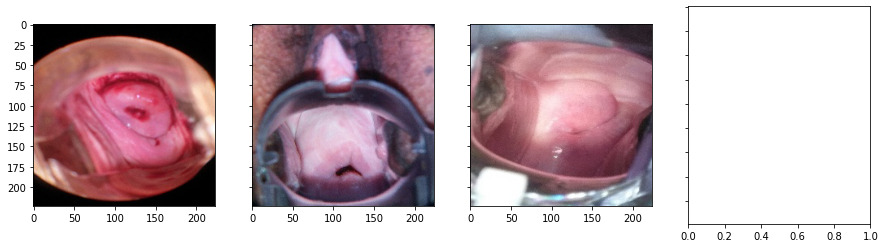

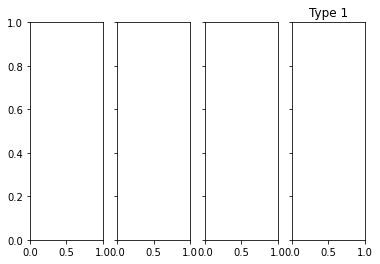

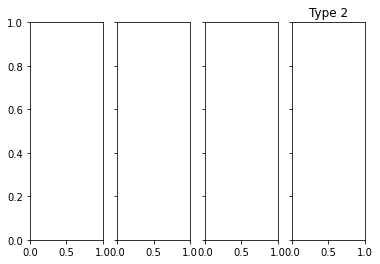

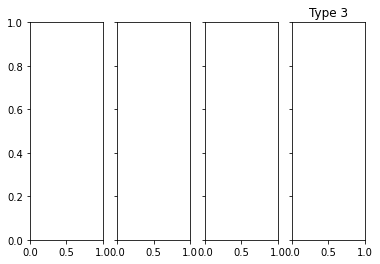

In [29]:

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
img_one = plt.imread('/content/drive/MyDrive/archive/kaggle/train/train/Type_1/0.jpg')
plt.subplots(1, 4, sharey=True)
plt.title ("Type 1")
ax1.imshow(img_one)

img_two = plt.imread('/content/drive/MyDrive/archive/kaggle/train/train/Type_2/1001.jpg')
plt.subplots(1, 4, sharey=True)
plt.title ("Type 2")
ax2.imshow(img_two)

img_three = plt.imread('/content/drive/MyDrive/archive/kaggle/train/train/Type_3/1008.jpg')
plt.subplots(1, 4, sharey = True)
plt.title ("Type 3")
ax3.imshow(img_three)

In [31]:
class MyDataset(Dataset):
  def __init__(self, paths, transform=None, train=True, size=224):
    self.paths = paths
    self.transform = transform
    self.train = train
    self.size = size

  def __len__(self):
    return len(self.paths)

  def __getItem__(self, idx):
     p = self.paths[idx]
     label = p.split("/")[-2].split("_")[-1]
     image = cv2.imread(p)
     image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
     return image, int(label) - 1 




In [34]:
class CancerDataset(Dataset):
  def __init__(self, df, x_col = "image", y_col = "target", augmentations = None):
    self.df = df
    self.features = df[x_col]
    self.targets = df[y_col]
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    image = self.features[idx].float()
    label = self.targets[idx]
    image = image.permute(2, 0, 1)
    if self.augmentations is not None:
      image = np.array(image)
      augmented = self.augmentations(image = image)
      image = torch.from_numpy(augmented['image'])
      image = image.float()
      return image, label

    return image, label

  def norm(img):
    img-=img.min()
    img=img/img.max()
    return img




In [39]:
transform = A.Compose([A.OneOf([A.Blur(blur_limit = 3),  A.MotionBlur(blur_limit=3)]),
                       A.GaussNoise(), A.Sharpen(), A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
                       A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT),
])

dataset = MyDataset(file_path, transform, train=True, size = 224)
train_loader = DataLoader(dataset, batch_size= batch_size)


In [ ]:
df = pd.DataFrame(columns =["image", "target"])
iter_loader = iter(train_loader)
#debug
for x,y in iter_loader:
  for i, (row,t) in enumerate(zip(x,y)):
    df = df.append({"image": row, "target":t.item()}, ignore_index=True)
df.head()

In [ ]:
#debug
sns.countplot(x='target', data=df, palette='pastel')  
plt.show()  